In [ ]:
import datetime as dt
import os
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [2]:
data_dir = Path(os.getcwd()).joinpath("data")

In [133]:
def load_data(stock_id: int, data_type: str):
    assert data_type in ["book", "trade"]
    file_dir = data_dir.joinpath(f"{data_type}_train.parquet").joinpath(f"stock_id={stock_id}")
    file_name = os.listdir(file_dir)[0]
    full_path = file_dir.joinpath(file_name)
    return pd.read_parquet(full_path)

In [407]:
def wap(df, wap2_wt=0):
    df['wap1'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['wap2'] = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    df[f'wap_{wap2_wt}'] = df['wap1'] * (1 - wap2_wt) + df['wap2'] * wap2_wt
    return df

def spread_ratio(df):
    df['spread_ratio'] = (df['ask_price1'] / df['bid_price1'] - 1) * 10000
    return df

def volume_imbalance(df):
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    return df

def realized_volatility(series, shift_size=1):
    x = np.log(series).diff(shift_size)
    return np.sqrt(np.sum(x**2))

def calc_rvol(x: pd.Series, ewa_alpha: float, shift_size: int):
    x = x.ewm(alpha=ewa_alpha).mean()
    x = np.log(x).diff(shift_size)
    return np.sqrt(np.sum(x**2))

In [164]:
df_book0 = load_data(stock_id=0, data_type="book")
df_book = df_book0.copy()

df_trade0 = load_data(stock_id=0, data_type="trade")
df_trade = df_trade0.copy()

In [165]:
grid = {
    "wap_wt": [0, 0.15],
    "ewa_alpha": [0.2, 0.6, 1],
    "shift_size": [1, 3, 5]
}

for wap_wt in grid['wap_wt']:
    df_book = wap(df_book, wap2_wt=wap_wt)

df_book = spread_ratio(df_book)
df_book = volume_imbalance(df_book)
df_book

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap1,wap2,wap_0,wap_0.15,spread_ratio,volume_imbalance
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,1.001434,1.001390,1.001434,1.001427,8.779764,321
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,1.001448,1.001390,1.001448,1.001439,8.779764,195
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,1.001448,1.001391,1.001448,1.001439,8.779764,195
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,1.001443,1.001391,1.001443,1.001435,8.779764,221
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,1.001443,1.001391,1.001443,1.001435,8.779764,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28,0.998515,0.998522,0.998515,0.998516,4.799366,20
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28,0.998516,0.998817,0.998516,0.998561,4.799366,173
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28,0.998516,0.998715,0.998516,0.998546,4.799366,73
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28,0.998517,0.998715,0.998517,0.998547,4.799366,74


In [ ]:


def extract_features(dfb, dft):
    features = dict()

    for wap_wt, ewa_alpha, shift_size in itertools.product(*grid.values()):
        features[f'rvol_{wap_wt}_{ewa_alpha}_{shift_size}'] = realized_volatility(
            dfb[f'wap_{wap_wt}'].ewm(alpha=ewa_alpha).mean(),
            shift_size=shift_size
        )

    features['spread_ratio_mean'] = dfb['spread_ratio'].mean()
    features['spread_ratio_std'] = dfb['spread_ratio'].std()
    features['volume_imbalance_mean'] = dfb['volume_imbalance'].mean()

    features['trade_volume'] = dft['size'].sum()
    features['trade_count'] = dft['order_count'].sum()

    return features


time_ids = df_book['time_id'].unique()

rows = []
for time_id in time_ids:
    row = {
        'time_id': time_id,
    }
    dfb = df_book[df_book['time_id'] == time_id]
    dft = df_trade[df_trade['time_id'] == time_id]
    row.update(extract_features(dfb, dft))
    rows.append(row)

df_features = pd.DataFrame(rows)
df_features

In [169]:
time_ids = df_book['time_id'].unique()

rows = []
for time_id in time_ids:
    row = {
        'time_id': time_id,
    }
    dfb = df_book[df_book['time_id'] == time_id]
    dft = df_trade[df_trade['time_id'] == time_id]
    row.update(extract_features(dfb, dft))
    rows.append(row)

df_features = pd.DataFrame(rows)
df_features

,time_id,rvol_0_0.2_1,rvol_0_0.2_3,rvol_0_0.2_5,rvol_0_0.6_1,rvol_0_0.6_3,rvol_0_0.6_5,rvol_0_1_1,rvol_0_1_3,rvol_0_1_5,...,rvol_0.15_0.6_3,rvol_0.15_0.6_5,rvol_0.15_1_1,rvol_0.15_1_3,rvol_0.15_1_5,spread_ratio_mean,spread_ratio_std,volume_imbalance_mean,trade_volume,trade_count
0,5,0.001141,0.002906,0.004391,0.002651,0.005089,0.006629,0.004499,0.006449,0.007715,...,0.004688,0.006222,0.003942,0.005861,0.007139,8.522232,2.115167,134.894040,3179,110
1,11,0.000294,0.000689,0.000984,0.000701,0.001268,0.001467,0.001204,0.001703,0.001752,...,0.001080,0.001252,0.001020,0.001454,0.001489,3.942811,1.572313,142.050000,1289,57
2,16,0.000675,0.001688,0.002573,0.001389,0.002666,0.003601,0.002369,0.003350,0.004106,...,0.002499,0.003458,0.002165,0.003070,0.003893,7.254260,1.636399,141.414894,2161,68
3,31,0.000736,0.001925,0.002863,0.001611,0.003390,0.004499,0.002574,0.004171,0.005139,...,0.003291,0.004379,0.002463,0.004044,0.004972,8.608392,2.802507,146.216667,1962,59
4,62,0.000493,0.001172,0.001639,0.001129,0.002168,0.002701,0.001894,0.002707,0.003205,...,0.001936,0.002449,0.001692,0.002420,0.002888,3.972501,1.300607,123.846591,1791,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,32751,0.000652,0.001511,0.002187,0.001518,0.002781,0.003415,0.002579,0.003622,0.004087,...,0.002670,0.003371,0.002355,0.003410,0.003967,5.523592,2.018904,197.144781,3450,159
3826,32753,0.000653,0.001644,0.002505,0.001358,0.002697,0.003683,0.002206,0.003294,0.004161,...,0.002583,0.003563,0.001944,0.003103,0.003971,5.425458,1.469272,233.781553,4547,109
3827,32758,0.000798,0.002035,0.003106,0.001768,0.003501,0.004797,0.002913,0.004328,0.005480,...,0.003282,0.004528,0.002584,0.004009,0.005121,5.251619,2.439505,115.829787,4250,126
3828,32763,0.000717,0.001754,0.002547,0.001796,0.003393,0.004174,0.003046,0.004413,0.004955,...,0.003249,0.004100,0.002772,0.004151,0.004779,4.803956,1.449588,132.074919,3217,114


In [172]:
x_train = df_features.drop(columns=['time_id']).values
x_train.shape

(3830, 23)

In [168]:
df_train = pd.read_csv(data_dir.joinpath("train.csv"))
df_train

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


In [173]:
y_train = df_train[df_train['stock_id'] == 0]['target'].values

In [175]:
y_train.shape

(3830,)

In [385]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import lightgbm as lgb


from sklearn.metrics import (
    root_mean_squared_error, r2_score, accuracy_score, precision_recall_curve,
    roc_auc_score, roc_curve, precision_score, recall_score, f1_score
)

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_rmspe(y_pred, lgb_train: lgb.Dataset):
    y_true = lgb_train.get_label()
    return 'RMSPE', round(rmspe(y_true, y_pred),8), False

In [ ]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)


In [399]:
params = {
    "objective": "rmse", 
    "metric": "rmse", 
    "boosting_type": "gbdt",
    # 'early_stopping_rounds': 30,
    # 'learning_rate': 0.01,
    # 'lambda_l1': 1,
    # 'lambda_l2': 1,
    # 'feature_fraction': 0.8,
    # 'bagging_fraction': 0.8,
}

x_train_lgb = lgb.Dataset(x_train_scaled, y_train)
model = lgb.train(params, x_train_lgb, valid_sets=[x_train_lgb], num_boost_round=500, feval=feval_rmspe)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5861
[LightGBM] [Info] Number of data points in the train set: 3830, number of used features: 23
[LightGBM] [Info] Start training from score 0.004028


In [400]:
model.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('rmse', 0.0005280680322329473),
                          ('RMSPE', 0.12548907)])})

In [401]:
import matplotlib.pyplot as plt

def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()

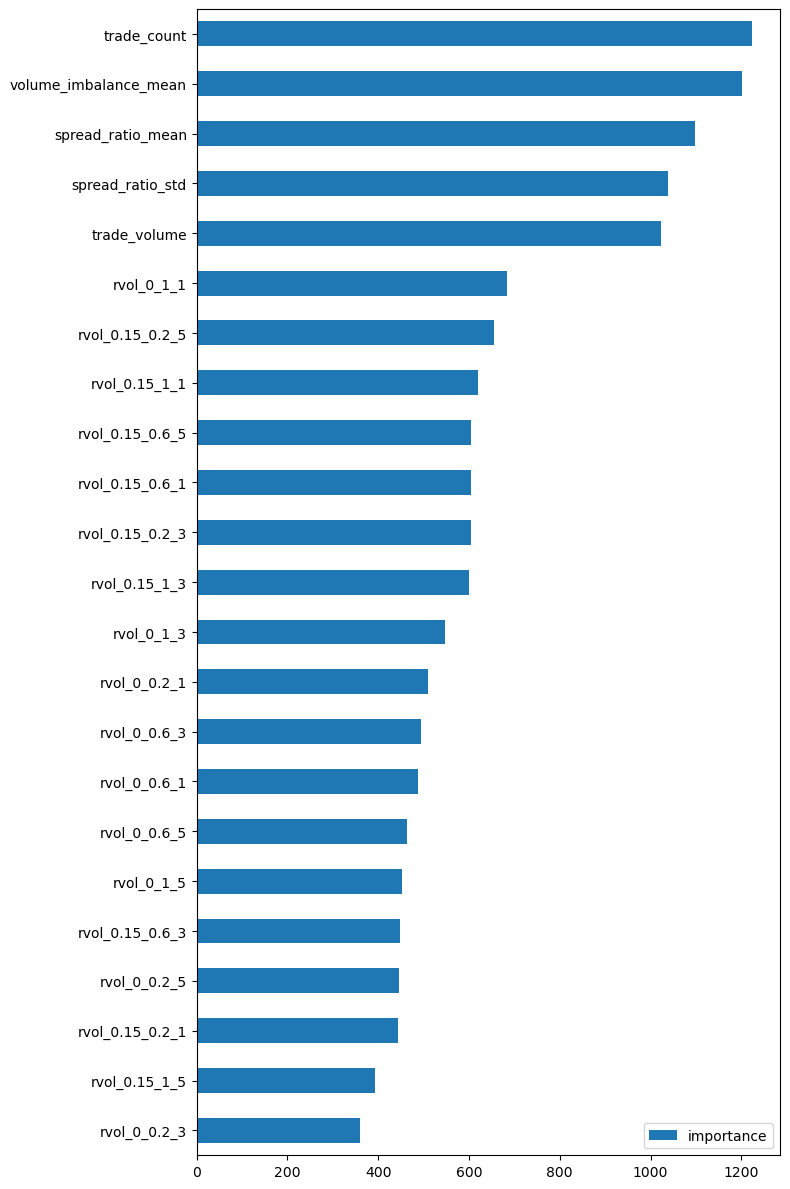

In [406]:
plot_importance(
    calc_model_importance(
        model, 
        feature_names=df_features.drop(columns=['time_id']).columns,
        importance_type='split'
    )
)


In [311]:
model = LinearRegression()
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_train_scaled)

print(f"RMSPE: {rmspe(y_train, y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_train, y_pred)}")

RMSPE: 0.3338907470946854
RMSE: 0.0014207779850296048


In [382]:
model = MLPRegressor(
    learning_rate_init=0.01, 
    hidden_layer_sizes=(64, 128, 128), 
    max_iter=100000,
)
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_train_scaled)

print(f"RMSPE: {rmspe(y_train, y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_train, y_pred)}")

RMSPE: 0.48013971974699665
RMSE: 0.0016022104944567964


RMSPE: 0.3338907470992466
R2: 0.7522487162446154
RMSE: 0.0014207779850296041


PHASE 1
- make a val
- plot it nicely
- make an rvol calculator (with half lives???)
- use past rvol as pred for future
- submit

PHASE 2
- Extend feauters 
-- Do some lit. review
- Build Simple models

PHASE 3
- Verrify Feature data/parallelisation is working?
- Implement LOOCV and parralelized grid search
- Create pipeline

-------------------------------------------------------

PHASE 4
- Create LSTM model
- Build CNN Features
    - Feature Eng Viz.
- Make Codebase?

PHASE 5
- Run Models 
- Visualize Results+



